<a href="https://colab.research.google.com/github/czhurdlespeed/TFDevCert/blob/main/TFCert_Practice/05_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF: Fine-tuning

In [21]:
# Check for GPU
!nvidia-smi

Wed Jan 17 15:09:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              26W /  70W |   2173MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-17 15:09:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-17 15:09:52 (96.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Use python modules to reuse functions
* Import them as modules

In [23]:
# Import Helper Functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


## Let's get some data
Use `tf.keras.applications`

In [24]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")


--2024-01-17 15:09:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  40.9MB/s    in 4.5s    

2024-01-17 15:09:57 (35.6 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [25]:
# Check out images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [26]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [27]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [28]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [29]:
# Check out class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [30]:
# See example of a batch off data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[ 20.586735   15.586735   11.586735 ]
   [ 18.428572   13.428571    9.428571 ]
   [ 17.785713   13.         10.       ]
   ...
   [196.87253   168.35725    76.79092  ]
   [196.11731   167.96938    76.2806   ]
   [191.91313   163.67342    73.80094  ]]

  [[ 20.         15.         11.       ]
   [ 18.071428   13.071428    9.071428 ]
   [ 16.785713   12.          9.       ]
   ...
   [186.72974   154.54091    57.413376 ]
   [191.0816    158.50511    61.5051   ]
   [187.59677   155.78564    60.57132  ]]

  [[ 21.07653    16.07653    13.07653  ]
   [ 19.285713   14.285714   11.285714 ]
   [ 18.         13.214286   10.306123 ]
   ...
   [179.14294   143.71437    50.35723  ]
   [183.71428   148.2857     55.07144  ]
   [176.709     141.28043    49.923286 ]]

  ...

  [[136.92862   131.92862   137.92862  ]
   [135.15825   130.15825   134.15825  ]
   [135.35722   131.35722   132.35722  ]
   ...
   [121.785736  110.785736  106.785736 ]
   [122.87248   111.87248   107.87248  ]
   [1

## Model 0: Transfer learning model using Keras Functional API

In [31]:
# 1. Create a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet, normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through the base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="gloabl_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outpus into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent, epochs=5, steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data, validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback("transferlearning","10_percent_feature_extraction")])

Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transferlearning/10_percent_feature_extraction/20240117-151005
Epoch 1/5
24/24 [==============================] - 13s 233ms/step - loss: 1.9485 - accuracy: 0.3693 - val_loss: 1.3415 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 4s 132ms/step - loss: 1.1241 - accuracy: 0.7573 - val_loss: 0.8836 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 5s 175ms/step - loss: 0.8040 - accuracy: 0.8227 - val_loss: 0.7122 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 4s 138ms/step - loss: 0.6472 - accuracy: 0.8653 - val_loss: 0.6196 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 4s 133ms/step - loss: 0.5540 - accuracy: 0.8773 - val_loss: 0.5800 - val_accuracy: 0.8701


In [32]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5616 - accuracy: 0.8648


[0.5616409778594971, 0.864799976348877]

In [33]:
# Check the layers of the model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [34]:
# summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, None, None, 3)        0         ['normalization_1

In [35]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 gloabl_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

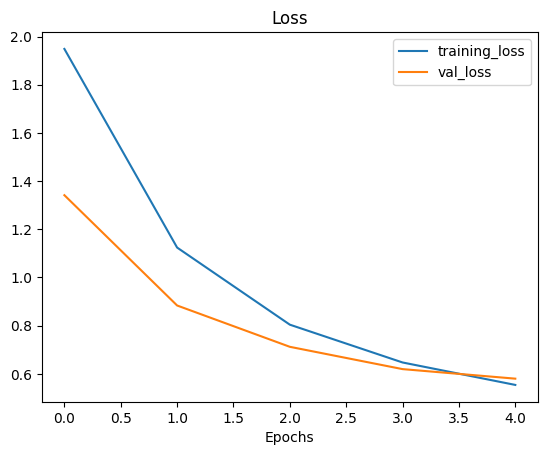

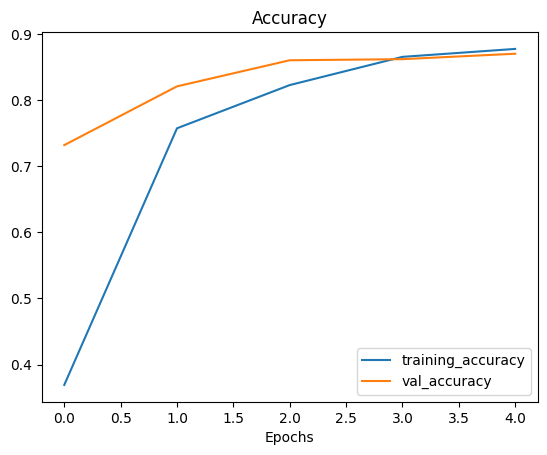

In [36]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model


In [37]:
# Define the input shape
input_shape = (1,4,4,3)
# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [38]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [39]:
# Check the shape ofthe different tensors
print(f"Shape of input tensor: {input_tensor.shape}\n")
print(f"Shape of gloabl average pooled tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)

Shape of gloabl average pooled tensor: (1, 3)


In [40]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer leearning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the traning data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

In [41]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-01-17 15:18:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  37.9MB/s    in 3.8s    

2024-01-17 15:18:25 (33.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [42]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir  = "10_food_classes_1_percent/test"

In [44]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [45]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.preprocessing()`

In [48]:
# By making the augmentation occur within the model e.g. as a layer, it uses the GPU instead of CPU for data augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = "data_augmentation_layer")

### Visualize our data augmentation layer (see what happens to our data)

10_food_classes_1_percent/train/pizza
10_food_classes_1_percent/train/pizza/1916846.jpg


Text(0.5, 1.0, 'Augmented random image from class pizza')

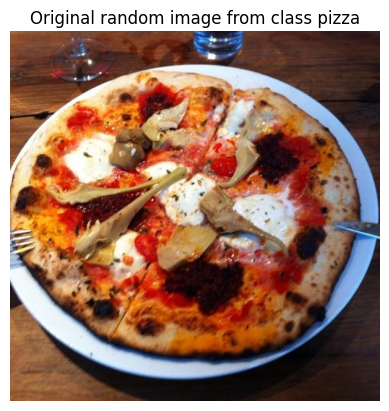

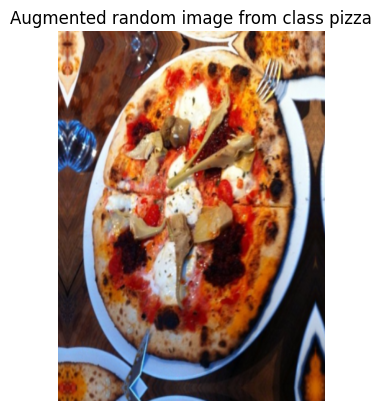

In [63]:
# view a random image and compare to augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
print(target_dir + "/" + random_image)
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_image = data_augmentation(img)
plt.figure()
plt.imshow(augmented_image/255.)
plt.axis(False)
plt.title(f"Augmented random image from class {target_class}")

# Model 1: Feature extraction transfer learning on 1% of all the training data

In [68]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_moel the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name="output_layer")(x)

# make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
history_1_percent = model_1.fit(train_data_1_percent, epochs=5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240117-161440
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3515 - accuracy: 0.1571 - val_loss: 2.2822 - val_accuracy: 0.1678
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1114 - accuracy: 0.2857 - val_loss: 2.1595 - val_accuracy: 0.2467
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9319 - accuracy: 0.3857 - val_loss: 2.0296 - val_accuracy: 0.2944
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7654 - accuracy: 0.5857 - val_loss: 1.9368 - val_accuracy: 0.3618
Epoch 5/5
3/3 [==============================] - 8s 3s/step - loss: 1.6077 - accuracy: 0.6286 - val_loss: 1.8352 - val_accuracy: 0.4375


In [69]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [70]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 73ms/step - loss: 1.8184 - accuracy: 0.4496


[1.818428874015808, 0.4496000111103058]

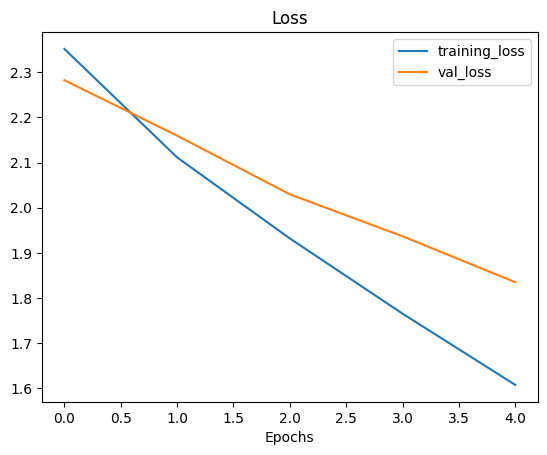

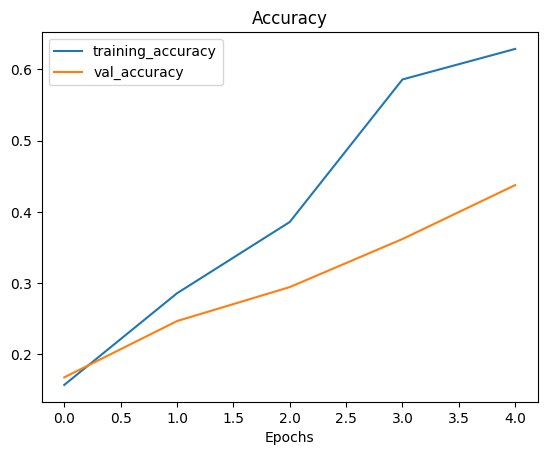

In [71]:
# How does the model with 1% of the data and data augmentation look?
plot_loss_curves(history_1_percent)

In [72]:
## Model 2: feature extraction transfer learning model with 10% of data and data augmentation
# get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [74]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [73]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode = "categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [77]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Create the inputs and outpus
inputs = layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to base model but model's weights don't get updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


71686520/71686520 [==============================] - 2s 0us/step


In [78]:
# Create model checkpoint - saves our model during training
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", verbose =1)

In [79]:
initial_epochs = 5
history_model_2_10_percent = model_2.fit(train_data_10_percent, epochs = initial_epochs,
            steps_per_epoch = len(train_data_10_percent),
            validation_data = test_data,
                                         validation_steps = int(0.25*len(test_data)),
                                         callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                  experiment_name = "10_percent_data_aug"),
                                                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240117-164313
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.8795 - accuracy: 0.4373
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 58s 2s/step - loss: 1.8795 - accuracy: 0.4373 - val_loss: 1.2883 - val_accuracy: 0.7566
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.7027
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 34s 1s/step - loss: 1.2196 - accuracy: 0.7027 - val_loss: 0.8808 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.7653
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 30s 1s/step - loss: 0.9240 - accuracy: 0.7653 - val_loss: 0.7218 - val_accuracy: 0.8207
Epoch 4/5


In [80]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 9s 81ms/step - loss: 0.5616 - accuracy: 0.8648


[0.5616407990455627, 0.864799976348877]

In [81]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 13s 160ms/step - loss: 0.5933 - accuracy: 0.8328


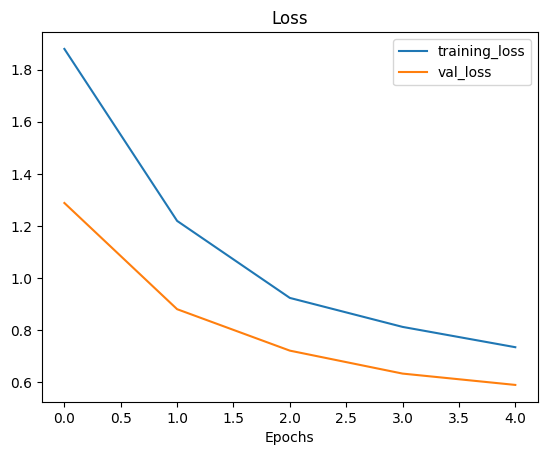

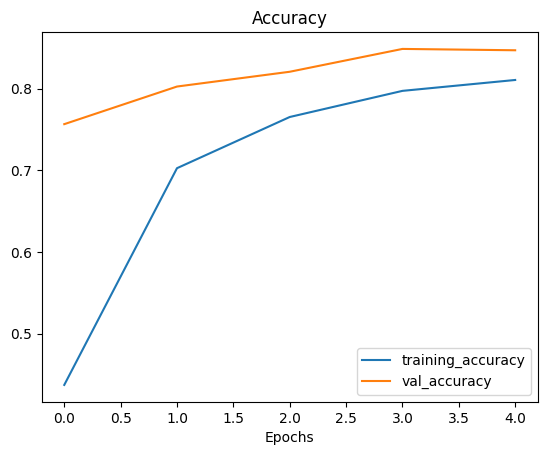

In [82]:
# Plot model loss curves
plot_loss_curves(history_model_2_10_percent)